In [1]:
rm(list=rm())

In [2]:
setwd("C:/Users/qlian/OneDrive/Desktop/Grad Fall 2020 Courses/EAS 506 Statistical Mining I/WEEK8")

# Question 1

1) Consider the Diabetes dataset (posted with assignment). Assume the
population prior probabilities are estimated using the relative frequencies of the
classes in the data.
-  Produce pairwise scatterplots for all five variables, with different symbols or
colors representing the three different classes. Do you see any evidence that
the classes may have difference covariance matrices? That they may not be
multivariate normal?
- Apply linear discriminant analysis (LDA) and quadratic discriminant analysis
(QDA). How does the performance of QDA compare to that of LDA in this
case?
- Suppose an individual has (glucose test/intolerence = 68, insulin test =122,
SSPG = 544. Relative weight = 1.86, fasting plasma glucose = 184). To
which class does LDA assign this individual? To which class does QDA?

### Load the data

In [46]:
diabetes <- read.csv("Diabetes.csv")

In [35]:
head(diabetes)

X,relwt,glufast,glutest,instest,sspg,group
1,0.81,80,356,124,55,Normal
2,0.95,97,289,117,76,Normal
3,0.94,105,319,143,105,Normal
4,1.04,90,356,199,108,Normal
5,1.00,90,323,240,143,Normal
6,0.76,86,381,157,165,Normal


- let's drop the column "X" , which is just an indices column

In [47]:
diabetes<-diabetes[,-1]

In [48]:
dim(diabetes)

[1] 145   6

In [39]:
colSums(is.na(diabetes))

X   relwt glufast glutest instest    sspg   group 
      0       0       0       0       0       0       0

In [40]:
str(diabetes$group)

 Factor w/ 3 levels "Chemical_Diabetic",..: 2 2 2 2 2 2 2 2 2 2 ...


In [42]:
unique(diabetes$group)

[1] Normal            Chemical_Diabetic Overt_Diabetic   
Levels: Chemical_Diabetic Normal Overt_Diabetic

- we have three categories

## Question 1a
-  Produce pairwise scatterplots for all five variables, with different symbols or
colors representing the three different classes. Do you see any evidence that
the classes may have difference covariance matrices? That they may not be
multivariate normal?

In [ ]:
## library(psych)


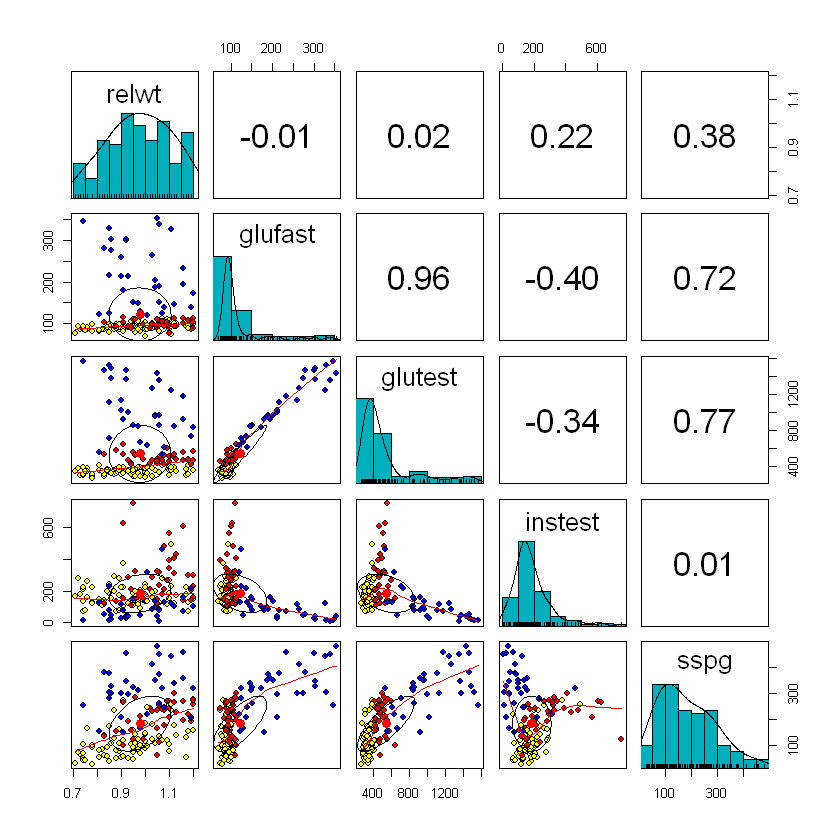

In [108]:
pairs.panels(diabetes[,-6], 
             hist.col = "#00AFBB",
             density = TRUE,  # show density plots
             ellipses = TRUE, # show correlation ellipses
             col = diabetes$group,
             bg=c("red","yellow","blue")[diabetes$group],
             pch=21
             )

- strong correlation between "glufast" and "glutest" 
- strong correlation between "sspg" and "glufast" 
- strong correlation between "sspg" and "glutest"

#### Normality
- By looking at the pair-wise plot above, we can see the univariate distribution of each variable, and bivariate distribution between each pair of variable:
    - univariate: first thing first we can see that "glufast", "glutest", "intest" are quite right skewed,  maybe we can do something about that later!
    - bivariate: a perfect bivariate normality between two variable would be a circular cloud, we don't really see that most pairs, maybe in "relwt"vs."sspg"


### Goodness of fit test for multivariate normality 

In [558]:
# install.packages('MVN')
# library(MVN)

In [81]:
as.numeric((diabetes[,-7])

[1] "data.frame"

In [99]:
mardia <- mvn(data = diabetes[,1:5], mvnTest = "mardia")

In [101]:
mardia$multivariateNormality

Test,Statistic,p value,Result
Mardia Skewness,402.412745893203,5.38979452469584e-64,NO
Mardia Kurtosis,11.647662518592,0,NO
MVN,NA,NA,NO


- the mardia test resulted in a high skewness and kurtosis values for multivariate normality test
- let's transform our data and try to force it into a "normal distribution"

#### Feature Transformation

In [142]:
names(diabetes)

[1] "relwt"   "glufast" "glutest" "instest" "sspg"    "group"

In [161]:
log_glufast = log(diabetes$glufast+5)
log_glutest = log(diabetes$glutest+5)
log_instest = log(diabetes$instest+5)
log_sspg = log(diabetes$sspg+5)
relwt = diabetes$relwt
group = diabetes$group

In [164]:
head(group)

[1] Normal Normal Normal Normal Normal Normal
Levels: Chemical_Diabetic Normal Overt_Diabetic

In [168]:
new <- cbind.data.frame(relwt,log_glufast,log_glutest,log_instest,log_sspg,group)

In [169]:
head(new)

relwt,log_glufast,log_glutest,log_instest,log_sspg,group
0.81,4.442651,5.888878,4.859812,4.094345,Normal
0.95,4.624973,5.683580,4.804021,4.394449,Normal
0.94,4.700480,5.780744,4.997212,4.700480,Normal
1.04,4.553877,5.888878,5.318120,4.727388,Normal
1.00,4.553877,5.793014,5.501258,4.997212,Normal
0.76,4.510860,5.955837,5.087596,5.135798,Normal


#### Let's check normality again

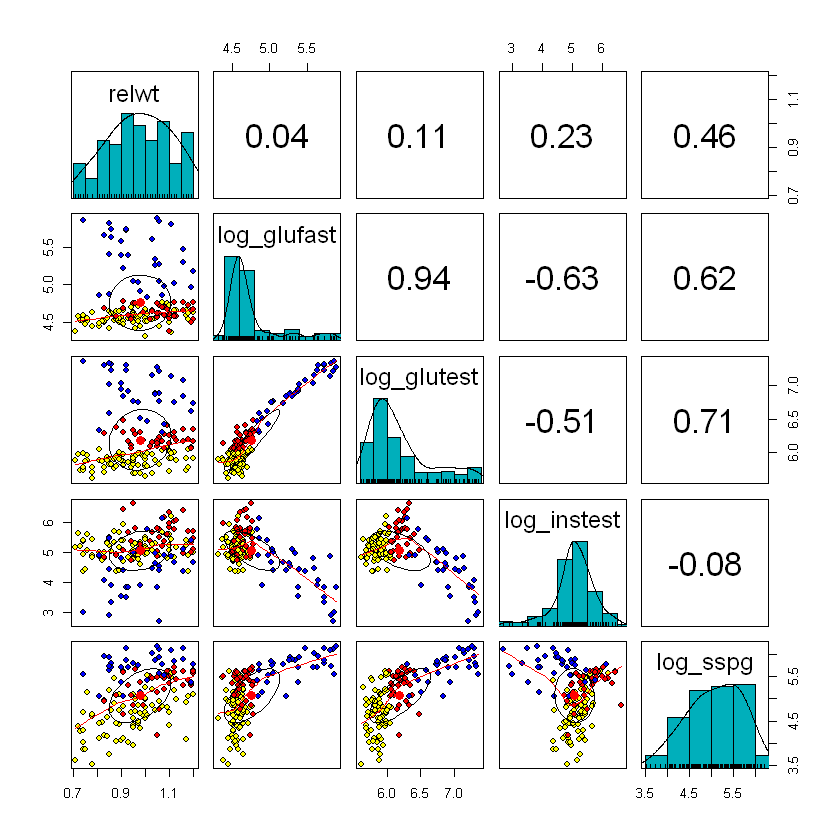

In [152]:
pairs.panels(new, 
             hist.col = "#00AFBB",
             density = TRUE,  # show density plots
             ellipses = TRUE, # show correlation ellipses
             col = diabetes$group,
             bg=c("red","yellow","blue")[diabetes$group],
             pch=21
             )

In [156]:
mardia_new <- mvn(data = new, mvnTest = "mardia")

In [158]:
mardia_new$multivariateNormality

Test,Statistic,p value,Result
Mardia Skewness,125.302837275659,4.33627223238337e-12,NO
Mardia Kurtosis,0.70376259018959,0.481580634515705,YES
MVN,NA,NA,NO


- slightly better than before, however not ideal!

## Question 1b
- Apply linear discriminant analysis (LDA) and quadratic discriminant analysis
(QDA). How does the performance of QDA compare to that of LDA in this
case?


### Train test split
- since we only have 145 datapoints, let's do a 1/3 and 2/3 split, so we can ensure that we have enough for testing
- before we split the data, we should check if there's an imbalance in the dataset, if there is we should consider stratified splitting to avoid an unfortunate split. (Although, in a dataset this small, stratified splitting is a good idea regardless!)

In [66]:
summary(diabetes$group)

Chemical_Diabetic            Normal    Overt_Diabetic 
               36                76                33

- we can see that class "Normal" has slightly twice as many data points than the other two categories, more reason to perform stratified splitting!

In [170]:
chemical <- new[diabetes$group=="Chemical_Diabetic",]
normal <- new[diabetes$group=="Normal",]
overt <- new[diabetes$group=="Overt_Diabetic",]

In [171]:
set.seed(479284732)

In [172]:
indi_chemical <- sample(1:nrow(chemical), nrow(chemical)*(2/3))
indi_normal <- sample(1:nrow(normal), nrow(normal)*(2/3))
indi_overt <- sample(1:nrow(overt), nrow(overt)*(2/3))


In [173]:
diabetes_train<- rbind(chemical[indi_chemical,], normal[indi_normal,], overt[indi_overt,])
diabetes_test<- rbind(chemical[-indi_chemical,], normal[-indi_normal,], overt[-indi_overt,])

In [174]:
dim(diabetes_train)
dim(diabetes_test)

[1] 96  6

[1] 49  6

In [178]:
summary(diabetes_train$group)

Chemical_Diabetic            Normal    Overt_Diabetic 
               24                50                22

In [177]:
summary(diabetes_test$group)

Chemical_Diabetic            Normal    Overt_Diabetic 
               12                26                11

Voila! we retained the ratio of classes in both sets

### Linear Discriminant Analysis (LDA)

In [557]:
# library(MASS)
# library(caret)

In [181]:
lda_fit = lda(group~.,data=diabetes_train)

In [182]:
lda_fit

Call:
lda(group ~ ., data = diabetes_train)

Prior probabilities of groups:
Chemical_Diabetic            Normal    Overt_Diabetic 
        0.2500000         0.5208333         0.2291667 

Group means:
                      relwt log_glufast log_glutest log_instest log_sspg
Chemical_Diabetic 1.0854167    4.632261    6.197395    5.525188 5.328835
Normal            0.9378000    4.557081    5.862832    5.095112 4.683200
Overt_Diabetic    0.9868182    5.364782    6.905421    4.459041 5.733872

Coefficients of linear discriminants:
                   LD1        LD2
relwt        1.3873107  4.1102565
log_glufast -0.8867316 -6.5104937
log_glutest  6.4987563  4.6532668
log_instest  0.4754850  0.3981816
log_sspg     0.1505448  0.1377024

Proportion of trace:
   LD1    LD2 
0.8805 0.1195 

In [183]:
lda_pred_train <-predict(lda_fit,newdata=diabetes_train)

In [203]:
y_train_pred_lda <- lda_pred_train$class

In [204]:
lda_cm_train <- confusionMatrix(as.factor(y_train_pred_lda),as.factor(diabetes_train$group))

In [190]:
lda_cm_train

Confusion Matrix and Statistics

                   Reference
Prediction          Chemical_Diabetic Normal Overt_Diabetic
  Chemical_Diabetic                22      2              5
  Normal                            2     48              0
  Overt_Diabetic                    0      0             17

Overall Statistics
                                          
               Accuracy : 0.9062          
                 95% CI : (0.8295, 0.9562)
    No Information Rate : 0.5208          
    P-Value [Acc > NIR] : 4.369e-16       
                                          
                  Kappa : 0.847           
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Chemical_Diabetic Class: Normal
Sensitivity                            0.9167        0.9600
Specificity                            0.9028        0.9565
Pos Pred Value                         0.7586        0.9600
Neg Pred Value              

In [191]:
lda_pred_test <-predict(lda_fit,newdata=diabetes_test)

In [200]:
y_test_pred_lda <- lda_pred_test$class

In [201]:
lda_cm_test <- confusionMatrix(as.factor(y_test_pred_lda),as.factor(diabetes_test$group))

In [202]:
lda_cm_test

Confusion Matrix and Statistics

                   Reference
Prediction          Chemical_Diabetic Normal Overt_Diabetic
  Chemical_Diabetic                12      2              2
  Normal                            0     24              0
  Overt_Diabetic                    0      0              9

Overall Statistics
                                         
               Accuracy : 0.9184         
                 95% CI : (0.804, 0.9773)
    No Information Rate : 0.5306         
    P-Value [Acc > NIR] : 4.686e-09      
                                         
                  Kappa : 0.8681         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: Chemical_Diabetic Class: Normal
Sensitivity                            1.0000        0.9231
Specificity                            0.8919        1.0000
Pos Pred Value                         0.7500        1.0000
Neg Pred Value                       

### Quadratic Discriminant Analysis (QDA)

In [196]:
qda_fit = qda(group~.,data=diabetes_train)

In [197]:
qda_fit

Call:
qda(group ~ ., data = diabetes_train)

Prior probabilities of groups:
Chemical_Diabetic            Normal    Overt_Diabetic 
        0.2500000         0.5208333         0.2291667 

Group means:
                      relwt log_glufast log_glutest log_instest log_sspg
Chemical_Diabetic 1.0854167    4.632261    6.197395    5.525188 5.328835
Normal            0.9378000    4.557081    5.862832    5.095112 4.683200
Overt_Diabetic    0.9868182    5.364782    6.905421    4.459041 5.733872

In [198]:
qda_pred_train <-predict(qda_fit,newdata=diabetes_train)

In [206]:
y_pred_train_qda <- qda_pred_train$class

In [208]:
qda_cm_train <- confusionMatrix(as.factor(y_pred_train_qda),as.factor(diabetes_train$group))

In [209]:
qda_cm_train

Confusion Matrix and Statistics

                   Reference
Prediction          Chemical_Diabetic Normal Overt_Diabetic
  Chemical_Diabetic                24      1              0
  Normal                            0     49              0
  Overt_Diabetic                    0      0             22

Overall Statistics
                                          
               Accuracy : 0.9896          
                 95% CI : (0.9433, 0.9997)
    No Information Rate : 0.5208          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9831          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Chemical_Diabetic Class: Normal
Sensitivity                            1.0000        0.9800
Specificity                            0.9861        1.0000
Pos Pred Value                         0.9600        1.0000
Neg Pred Value              

In [210]:
qda_pred_test <-predict(qda_fit,newdata=diabetes_test)

In [212]:
y_pred_test_qda <- qda_pred_test$class

In [213]:
qda_cm_test <- confusionMatrix(as.factor(y_pred_test_qda),as.factor(diabetes_test$group))

In [214]:
qda_cm_test

Confusion Matrix and Statistics

                   Reference
Prediction          Chemical_Diabetic Normal Overt_Diabetic
  Chemical_Diabetic                 9      2              0
  Normal                            1     24              0
  Overt_Diabetic                    2      0             11

Overall Statistics
                                         
               Accuracy : 0.898          
                 95% CI : (0.7777, 0.966)
    No Information Rate : 0.5306         
    P-Value [Acc > NIR] : 3.843e-08      
                                         
                  Kappa : 0.834          
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: Chemical_Diabetic Class: Normal
Sensitivity                            0.7500        0.9231
Specificity                            0.9459        0.9565
Pos Pred Value                         0.8182        0.9600
Neg Pred Value                       

In [218]:
lda_train_accuracy = lda_cm_train$overall['Accuracy']
lda_test_accuracy = lda_cm_test$overall['Accuracy']
qda_train_accuracy = qda_cm_train$overall['Accuracy']
qda_test_accuracy = qda_cm_test$overall['Accuracy']

In [220]:
rbind(lda_train_accuracy,lda_test_accuracy,qda_train_accuracy,qda_test_accuracy)

,Accuracy
lda_train_accuracy,0.9062500
lda_test_accuracy,0.9183673
qda_train_accuracy,0.9895833
qda_test_accuracy,0.8979592


- We can compare the performance of lda and qda on both training and testing sets by examining their accuracies (this is just 1- mse). We can see that qda performed a lot better on the training set than lda (around 8%), however, it performed slightly worse on the testing set than lda (around 1%). 
- Overall, we can make the conclusion that, both lda and qda have performed similarly, in this case lda is computationally less expensive to perform.

## Question 1c
Suppose an individual has (glucose test/intolerence = 68, insulin test =122, SSPG = 544. Relative weight = 1.86, fasting plasma glucose = 184). To which class does LDA assign this individual? To which class does QDA?

In [257]:
xi <- cbind(1.86,log(184+5),log(68+5),log(122+5),log(544+5))

In [261]:
xi <- data.frame(setNames(xi, c('relwt','log_glufast','log_glutest','log_instest','log_sspg')))

In [262]:
xi

relwt,log_glufast,log_glutest,log_instest,log_sspg
1.86,5.241747,4.290459,4.844187,6.308098


In [267]:
yi_lda <-predict(lda_fit,newdata=xi)$class

In [268]:
yi_lda

[1] Normal
Levels: Chemical_Diabetic Normal Overt_Diabetic

In [271]:
yi_qda <-predict(qda_fit,newdata=xi)$class

In [272]:
yi_qda

[1] Normal
Levels: Chemical_Diabetic Normal Overt_Diabetic

- Given the information provided (a new datapoint), and by using the models we generated for both lda and qda, we can use these to predict the class that the new datapoint most likely belong in (by maximizing it's likihood)! As we can see that both lda and qda have predicted the new data point xi to belong int the class "normal".

# Question 2
his question uses the “Weekly” dataset in the ISLR package. The
data contains information for weekly returns for 21 years, beginning in 1990 and
ending in 2010.
- Produce some numerical and graphical summaries of the “Weekly” data. Do
there appear to be any patterns?
- Use the full data to perform logistic regression with “Direction” as the response
and the five lag variables, plus volume, as predictors. Use the summary
function to print the results. Do any of the predictors appear to be statistically
significant? Comment on these.
- Compute the “confusion matrix” and overall fraction of correct predictions.
Explain what the confusion matrix is telling you about the types of mistakes
made by logistic regression.
- Fit the logistic model using a training data period from 1990-2008, with “Lag2”
as the only predictor. Compute the confusion matrix, and the overall correct
fraction of predictions (aka misclassification rate) for the held out data (that is,
the data from 2009 and 2010).
- Repeat (d) using LDA.
- Repeat (d) using KNN with k=1.
- Which method appears to provide the best results?
- Experiment with different combinations of predictors, including possible
transformations and interactions, for each method. Report the variables,
method, and associated confusion matrix that appears to provide the best results
on the held-out data. Note that you should also experiment with values for K
in the kNN cla

In [281]:
library(ISLR)
library(MASS)


In [353]:
data(Weekly)

In [328]:
head(Weekly)

Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
1990,0.816,1.572,-3.936,-0.229,-3.484,0.1549760,-0.270,Down
1990,-0.270,0.816,1.572,-3.936,-0.229,0.1485740,-2.576,Down
1990,-2.576,-0.270,0.816,1.572,-3.936,0.1598375,3.514,Up
1990,3.514,-2.576,-0.270,0.816,1.572,0.1616300,0.712,Up
1990,0.712,3.514,-2.576,-0.270,0.816,0.1537280,1.178,Up
1990,1.178,0.712,3.514,-2.576,-0.270,0.1544440,-1.372,Down


In [287]:
summary(Weekly)

      Year           Lag1               Lag2               Lag3         
 Min.   :1990   Min.   :-18.1950   Min.   :-18.1950   Min.   :-18.1950  
 1st Qu.:1995   1st Qu.: -1.1540   1st Qu.: -1.1540   1st Qu.: -1.1580  
 Median :2000   Median :  0.2410   Median :  0.2410   Median :  0.2410  
 Mean   :2000   Mean   :  0.1506   Mean   :  0.1511   Mean   :  0.1472  
 3rd Qu.:2005   3rd Qu.:  1.4050   3rd Qu.:  1.4090   3rd Qu.:  1.4090  
 Max.   :2010   Max.   : 12.0260   Max.   : 12.0260   Max.   : 12.0260  
      Lag4               Lag5              Volume            Today         
 Min.   :-18.1950   Min.   :-18.1950   Min.   :0.08747   Min.   :-18.1950  
 1st Qu.: -1.1580   1st Qu.: -1.1660   1st Qu.:0.33202   1st Qu.: -1.1540  
 Median :  0.2380   Median :  0.2340   Median :1.00268   Median :  0.2410  
 Mean   :  0.1458   Mean   :  0.1399   Mean   :1.57462   Mean   :  0.1499  
 3rd Qu.:  1.4090   3rd Qu.:  1.4050   3rd Qu.:2.05373   3rd Qu.:  1.4050  
 Max.   : 12.0260   Max.   : 12.0

## Question 2a
- Produce some numerical and graphical summaries of the “Weekly” data. Do
there appear to be any patterns?

In [316]:
names(Weekly)

[1] "Year"      "Lag1"      "Lag2"      "Lag3"      "Lag4"      "Lag5"     
[7] "Volume"    "Today"     "Direction"

In [317]:
lag = Weekly[,-c(1,7,9)]
lag_mean = c()
lag_median = c()
for (i in 1:6) {
  lag_mean[i] =  mean(lag[,i])
  lag_median[i]  = median(lag[,i])
 
}

In [320]:

name = names(lag)

In [321]:
cbind.data.frame(name,lag_mean,lag_median)

name,lag_mean,lag_median
Lag1,0.1505849,0.241
Lag2,0.1510790,0.241
Lag3,0.1472048,0.241
Lag4,0.1458182,0.238
Lag5,0.1398926,0.234
Today,0.1498990,0.241


- the range for return regardless of what weeks is the same, mean and medians are very close to each other as well. 

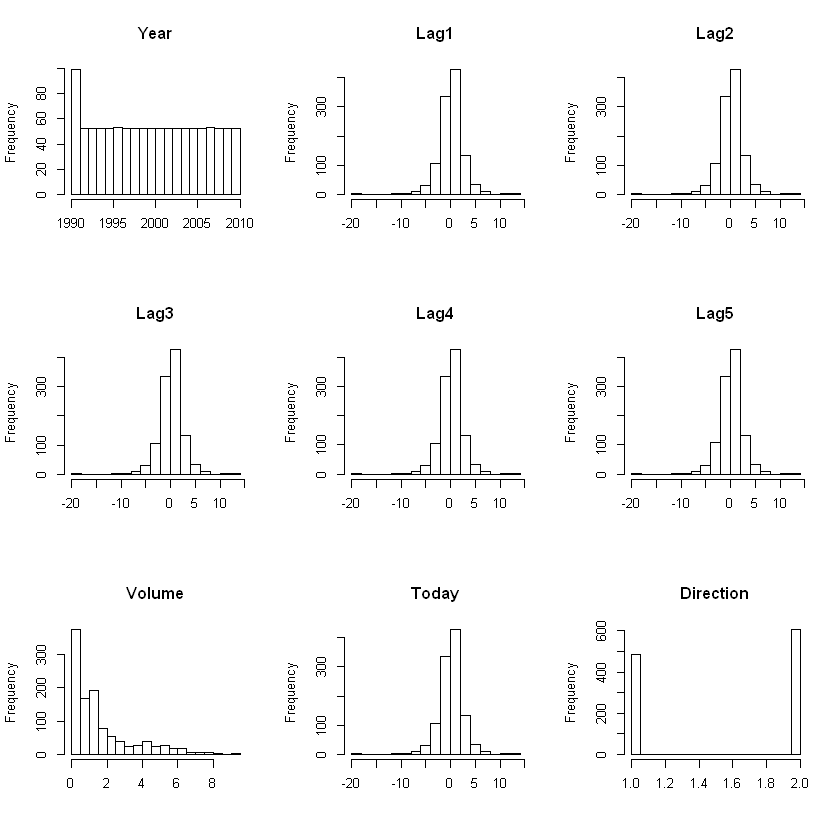

In [322]:
par(mfrow = c(3,3))
for (i in 1:9) {
  hist(as.numeric(Weekly[,i]),breaks = 20,main=names(Weekly)[i],xlab=NULL)
}

- we can see that most of return variables are normally distributed and has a lower standard deviation.
- "Volume" is right skewed - we can perform log transformation on this
- "Year" mostly uniformly distributed, except for in 1990, a lot of data is collected
- "Direction"- our response variable, we have two levels up and down, we don't seem to have an imbalanced dataset.

#### Transform "Volume" Variable

In [358]:
log_Volume = log(Weekly$Volume)

In [360]:
temp = Weekly[,-c(7,9)]

In [361]:
Direction = Weekly$Direction

In [362]:
Weekly = cbind.data.frame(temp,log_Volume,Direction)

In [363]:
head(Weekly)

Year,Lag1,Lag2,Lag3,Lag4,Lag5,Today,log_Volume,Direction
1990,0.816,1.572,-3.936,-0.229,-3.484,-0.270,-1.864485,Down
1990,-0.270,0.816,1.572,-3.936,-0.229,-2.576,-1.906672,Down
1990,-2.576,-0.270,0.816,1.572,-3.936,3.514,-1.833598,Up
1990,3.514,-2.576,-0.270,0.816,1.572,0.712,-1.822446,Up
1990,0.712,3.514,-2.576,-0.270,0.816,1.178,-1.872570,Up
1990,1.178,0.712,3.514,-2.576,-0.270,-1.372,-1.867924,Down


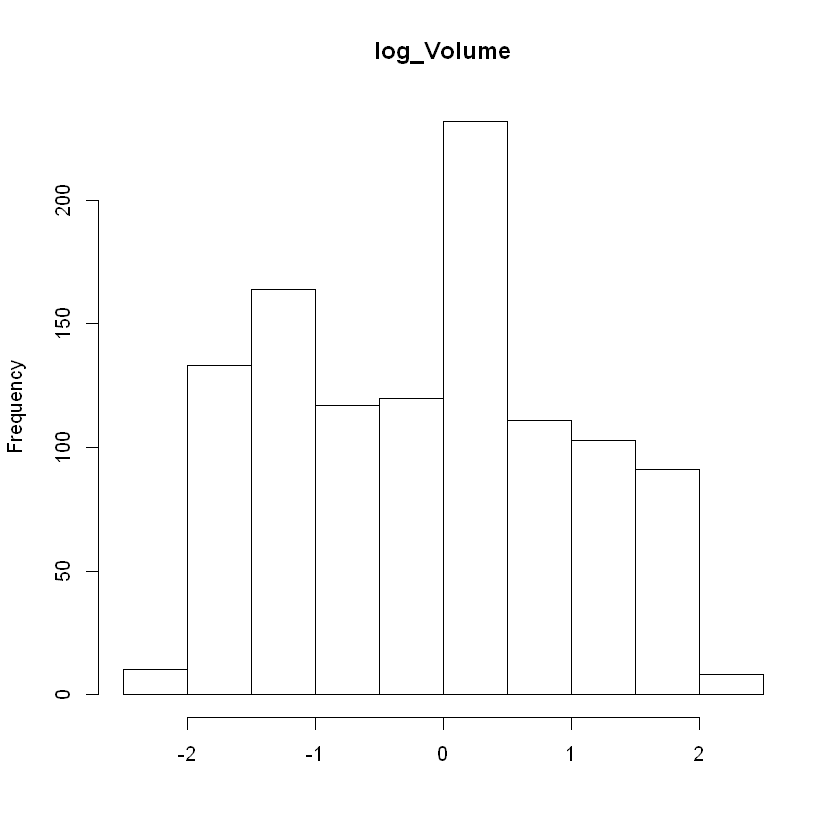

In [365]:
hist(log_Volume,main ="log_Volume",xlab=NULL)

- the histogram of log_Volume looks like a bell curve!

### Correlation Plot

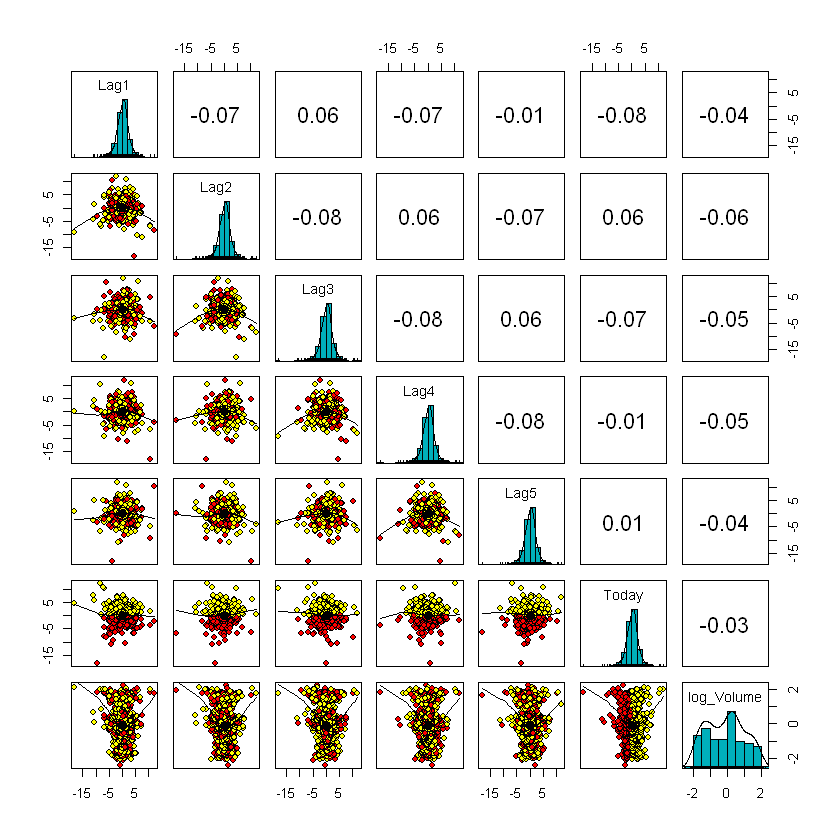

In [367]:
pairs.panels(Weekly[,-c(1,9)], 
             hist.col = "#00AFBB",
             density = TRUE,  # show density plots
             ellipses = TRUE, # show correlation ellipses
             col = Weekly$Direction,
             bg=c("red","yellow")[Weekly$Direction],
             pch=21
             )

- no outstanding high correlation between any two variables
- we can also see bivariate normality for most pairs of variables, we can we do more normality tests later.
- we can also see in the bivariate scatter plots between "Today" variable to other variables, we can see very well separated clusters between two classes (might not be stable for logistic regression)

## Question 2b
 - Use the full data to perform logistic regression with “Direction” as the response
and the five lag variables, plus volume, as predictors. Use the summary
function to print the results. Do any of the predictors appear to be statistically
significant? Comment on these. 

In [369]:
Weekly_log_reg = Weekly[,-7]

- dropping "today" variables

In [370]:
log_reg_fit <-glm(Direction ~.,data=Weekly_log_reg, family="binomial")

In [372]:
summary(log_reg_fit)


Call:
glm(formula = Direction ~ ., family = "binomial", data = Weekly_log_reg)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6578  -1.2590   0.9901   1.0796   1.4747  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)  
(Intercept) -96.33447  117.94679  -0.817   0.4141  
Year          0.04827    0.05896   0.819   0.4130  
Lag1         -0.04294    0.02643  -1.625   0.1042  
Lag2          0.05454    0.02716   2.008   0.0446 *
Lag3         -0.01807    0.02671  -0.677   0.4987  
Lag4         -0.02972    0.02651  -1.121   0.2622  
Lag5         -0.01625    0.02642  -0.615   0.5385  
log_Volume   -0.31284    0.32430  -0.965   0.3347  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1496.2  on 1088  degrees of freedom
Residual deviance: 1485.2  on 1081  degrees of freedom
AIC: 1501.2

Number of Fisher Scoring iterations: 4


- we can see that only "Lag2" variables appears to be significant.

#### Enconde our response variables to 0 and 1

In [378]:
y_true_log_reg = as.numeric(Weekly_log_reg$Direction)-1

#### Predict

In [375]:
y_pred_log_reg <- round(predict(log_reg_fit,type="response",newdata=Weekly_log_reg))

In [394]:
head(cbind.data.frame(y_true_log_reg,y_pred_log_reg,Weekly$Direction))

y_true_log_reg,y_pred_log_reg,Weekly$Direction
0,1,Down
0,1,Down
1,1,Up
1,0,Up
1,1,Up
0,1,Down


In [381]:
MSE_log_reg = MSE(y_pred_log_reg,y_true_log_reg)

In [382]:
MSE_log_reg

[1] 0.4334252

- we actually got a quite high MSE values from performing logistic regression

#### Let's try again with our only significant variables "Lag2"

In [385]:
Weekly_log_reg_new = Weekly[,c(3,9)]

In [388]:
log_reg_fit_new <-glm(Direction ~.,data=Weekly_log_reg_new, family="binomial")

In [389]:
y_pred_log_reg_new <- round(predict(log_reg_fit_new,type="response",newdata=Weekly_log_reg_new))

In [392]:
MSE_log_reg_new = MSE(y_pred_log_reg_new,y_true_log_reg)

In [393]:
MSE_log_reg_new

[1] 0.4380165

- we didn't really see any improvement in the model. We can conclude that logistic regression actually performed pretty poorly on the Weekly dataset

## Question 2c
- Compute the “confusion matrix” and overall fraction of correct predictions.
Explain what the confusion matrix is telling you about the types of mistakes
made by logistic regression. 

In [434]:
cm_log_reg = confusionMatrix(as.factor(y_pred_log_reg),as.factor(y_true_log_reg),positive="1")

In [435]:
cm_log_reg

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  68  56
         1 416 549
                                          
               Accuracy : 0.5666          
                 95% CI : (0.5365, 0.5963)
    No Information Rate : 0.5556          
    P-Value [Acc > NIR] : 0.2417          
                                          
                  Kappa : 0.0518          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.9074          
            Specificity : 0.1405          
         Pos Pred Value : 0.5689          
         Neg Pred Value : 0.5484          
             Prevalence : 0.5556          
         Detection Rate : 0.5041          
   Detection Prevalence : 0.8861          
      Balanced Accuracy : 0.5240          
                                          
       'Positive' Class : 1               
                              

In [403]:
fp_rate = (416/1089)*100
fp_rate

[1] 38.20018

- We can tell from our confusion matrix, that we have a lot of false positives (about 38% of the total dataset), which gave us a low specificity value. We can say that our logistic model tends to predict return going up more often.

## Question 3d

- Fit the logistic model using a training data period from 1990-2008, with “Lag2”
as the only predictor. Compute the confusion matrix, and the overall correct
fraction of predictions (aka misclassification rate) for the held out data (that is,
the data from 2009 and 2010).

### Train test split

In [414]:
unique(Weekly$Year)

[1] 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
[16] 2005 2006 2007 2008 2009 2010

In [437]:
Weekly_train = Weekly[(Weekly$Year != 2009) & (Weekly$Year != 2009),]
Weekly_test = Weekly[(Weekly$Year == 2009) & (Weekly$Year == 2009),]


In [438]:
Weekly_train = Weekly_train[,c(3,9)]
Weekly_test = Weekly_test[,c(3,9)]


In [454]:
y_true_lag2_train = as.numeric(Weekly_train$Direction)-1
y_true_lag2_test = as.numeric(Weekly_test$Direction)-1

In [439]:
dim(Weekly_train)
dim(Weekly_test)


[1] 1037    2

[1] 52  2

### logistic regression

In [440]:
log_reg_lag2_fit <- glm(Direction ~.,data=Weekly_train, family="binomial")

In [441]:
summary(log_reg_lag2_fit)


Call:
glm(formula = Direction ~ ., family = "binomial", data = Weekly_train)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.598  -1.266   1.002   1.084   1.423  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.21446    0.06275   3.418 0.000632 ***
Lag2         0.07015    0.02809   2.497 0.012511 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1424.8  on 1036  degrees of freedom
Residual deviance: 1418.4  on 1035  degrees of freedom
AIC: 1422.4

Number of Fisher Scoring iterations: 4


In [446]:
y_pred_lag2_train <- round(predict(log_reg_lag2_fit,type="response",newdata=Weekly_train))

In [451]:
head(cbind.data.frame(y_pred_lag2_train,y_true_lag2_train,Weekly_train$Direction))

y_pred_lag2_train,y_true_lag2_train,Weekly_train$Direction
1,0,Down
1,0,Down
1,1,Up
1,1,Up
1,1,Up
1,0,Down


#### Test data 

In [448]:
y_pred_lag2_test <- round(predict(log_reg_lag2_fit,type="response",newdata=Weekly_test))

In [527]:
MSE_logreg_train_weekly = MSE(y_pred_lag2_train,y_true_lag2_train)
MSE_logreg_test_weekly = MSE(y_pred_lag2_test,y_true_lag2_test)

In [528]:
rbind(MSE_logreg_train_weekly,MSE_logreg_test_weekly)

MSE_logreg_train_weekly,0.4378014
MSE_logreg_test_weekly,0.4423077


In [460]:
cm_test_lag2 = confusionMatrix(as.factor(y_pred_lag2_test),as.factor(y_true_lag2_test),positive="1")

In [461]:
cm_test_lag2

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0  4  4
         1 19 25
                                          
               Accuracy : 0.5577          
                 95% CI : (0.4133, 0.6953)
    No Information Rate : 0.5577          
    P-Value [Acc > NIR] : 0.557522        
                                          
                  Kappa : 0.0386          
                                          
 Mcnemar's Test P-Value : 0.003509        
                                          
            Sensitivity : 0.8621          
            Specificity : 0.1739          
         Pos Pred Value : 0.5682          
         Neg Pred Value : 0.5000          
             Prevalence : 0.5577          
         Detection Rate : 0.4808          
   Detection Prevalence : 0.8462          
      Balanced Accuracy : 0.5180          
                                          
       'Positive' Class : 1               
                                    

- logistic regression performed on dataset only using "Lag2" as a variable (our most significant variable), we still got the similar result as before, when all variables were included. Same phenomenom can be observed, in the "new dataset", we can see that our model also resulted in a higher false positive rate, which resulted in low specificty value.

## Question 3e
- Repeat (d) using LDA.

In [463]:
lda_fit = lda(Direction~.,data=Weekly_train)

In [464]:
lda_fit

Call:
lda(Direction ~ ., data = Weekly_train)

Prior probabilities of groups:
     Down        Up 
0.4445516 0.5554484 

Group means:
            Lag2
Down -0.06443818
Up    0.29375174

Coefficients of linear discriminants:
           LD1
Lag2 0.4405173

In [469]:
lda_pred_train <-predict(lda_fit,newdata=Weekly_train)$class

In [481]:
cm_train_lag2_lda = confusionMatrix(as.factor(Weekly_train$Direction),as.factor(lda_pred_train),positive="Up")

In [482]:
cm_train_lag2_lda

Confusion Matrix and Statistics

          Reference
Prediction Down  Up
      Down   34 427
      Up     27 549
                                          
               Accuracy : 0.5622          
                 95% CI : (0.5314, 0.5927)
    No Information Rate : 0.9412          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0294          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.56250         
            Specificity : 0.55738         
         Pos Pred Value : 0.95312         
         Neg Pred Value : 0.07375         
             Prevalence : 0.94118         
         Detection Rate : 0.52941         
   Detection Prevalence : 0.55545         
      Balanced Accuracy : 0.55994         
                                          
       'Positive' Class : Up              
                           

In [483]:
lda_pred_test <-predict(lda_fit,newdata=Weekly_test)$class

In [484]:
cm_test_lag2_lda = confusionMatrix(as.factor(Weekly_test$Direction),as.factor(lda_pred_test),positive="Up")

In [485]:
cm_test_lag2_lda

Confusion Matrix and Statistics

          Reference
Prediction Down Up
      Down    4 19
      Up      4 25
                                          
               Accuracy : 0.5577          
                 95% CI : (0.4133, 0.6953)
    No Information Rate : 0.8462          
    P-Value [Acc > NIR] : 1.000000        
                                          
                  Kappa : 0.0386          
                                          
 Mcnemar's Test P-Value : 0.003509        
                                          
            Sensitivity : 0.5682          
            Specificity : 0.5000          
         Pos Pred Value : 0.8621          
         Neg Pred Value : 0.1739          
             Prevalence : 0.8462          
         Detection Rate : 0.4808          
   Detection Prevalence : 0.5577          
      Balanced Accuracy : 0.5341          
                                          
       'Positive' Class : Up              
                              

In [ ]:
MSE_lda_train_Weekly = as.numeric(1- cm_train_lag2_lda$overall['Accuracy'])
MSE_lda_test_Weekly = as.numeric(1- cm_test_lag2_lda$overall['Accuracy'])

In [492]:
MSE_lda_train_Weekly
MSE_lda_test_Weekly

[1] 0.4378014

[1] 0.4423077

- as we can see that MSE values for training and testing are not very similar to that of results from logistic regression. Interestingly, though, you we take a look at the confusion matrix (both training and testing) from LDA results. We can see that we have a lot of false negative results, we know that this would give us a low F1 score, and lower out sensitivity values. This is interesting, we can say that unlike logistic regression which tend to have more false positives and tend to predict positive returns. LDA tends to predict the stock having negative returns.

## Question 2f
- Repeat (d) using KNN with k=1

In [493]:
library(class)

Warning message:
"package 'class' was built under R version 3.6.3"

In [504]:
y_pred_train_knn <- knn(train = data.matrix(Weekly_train$Lag2), test = data.matrix(Weekly_train$Lag2), cl = data.matrix(y_true_lag2_train), k =1)

In [511]:
knn_cm_train <- confusionMatrix(as.factor(y_pred_train_knn),as.factor(y_true_lag2_train),positive="1")

In [512]:
knn_cm_train

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 440  22
         1  21 554
                                          
               Accuracy : 0.9585          
                 95% CI : (0.9445, 0.9698)
    No Information Rate : 0.5554          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9161          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9618          
            Specificity : 0.9544          
         Pos Pred Value : 0.9635          
         Neg Pred Value : 0.9524          
             Prevalence : 0.5554          
         Detection Rate : 0.5342          
   Detection Prevalence : 0.5545          
      Balanced Accuracy : 0.9581          
                                          
       'Positive' Class : 1               
                              

In [523]:
MSE_knn_train_weekly= as.numeric(1- knn_cm_train$overall['Accuracy'])

In [505]:
y_pred_test_knn <- knn(train = data.matrix(Weekly_test$Lag2), test = data.matrix(Weekly_test$Lag2), cl = data.matrix(y_true_lag2_test), k =1)

In [524]:
knn_cm_test <- confusionMatrix(as.factor(y_pred_test_knn),as.factor(y_true_lag2_test),positive="1")

In [525]:
knn_cm_test

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 23  0
         1  0 29
                                     
               Accuracy : 1          
                 95% CI : (0.9315, 1)
    No Information Rate : 0.5577     
    P-Value [Acc > NIR] : 6.494e-14  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.5577     
         Detection Rate : 0.5577     
   Detection Prevalence : 0.5577     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : 1          
                                     

In [526]:
MSE_knn_test_weekly = as.numeric(1- knn_cm_test$overall['Accuracy'])

In [533]:
rbind(MSE_knn_train_weekly,MSE_knn_test_weekly)

MSE_knn_train_weekly,0.04146577
MSE_knn_test_weekly,0.00000000


- After performing KNN, we can see that MSE's are significantly smaller in both training and testing sets than the other two methos (logistic regression and LDA). 

## Question 3g
- Which method appears to provide the best results?

In [531]:
MSE_values = rbind(MSE_logreg_train_weekly,MSE_logreg_test_weekly,MSE_lda_train_Weekly,MSE_lda_test_Weekly,MSE_knn_train,MSE_knn_test)

In [532]:
MSE_values

MSE_logreg_train_weekly,0.43780135
MSE_logreg_test_weekly,0.44230769
MSE_lda_train_Weekly,0.43780135
MSE_lda_test_Weekly,0.44230769
MSE_knn_train,0.04146577
MSE_knn_test,0.00000000


- It is very apparent in this case that KNN out performed both logistic regression and LDA by a LOT! Not only KNN results have significantly lower MSE values, it also didnt suffer from the problems that the other two methods. Logistic regression resulted in high false positive cases which would drove down the specificity value. And on the other end, LDA resuled in high false negative cases which drove down the sensitivity values. 

## Question 3h
- Experiment with different combinations of predictors, including possible
transformations and interactions, for each method. Report the variables,
method, and associated confusion matrix that appears to provide the best results
on the held-out data. Note that you should also experiment with values for K
in the kNN classifier. 

- One thing I am quite curious about, is LDA's performance on dataset including the "today" variable. We can tell from our pair wise plots, that classes are well separated in the bivariate plots of "today" variable with other variables. Since LDA is based on maximizing the separability between classes, LDA ideally should perform well. 
- Let's try it on dataset only including today variable first!

#### Split the data same way as before

In [537]:
train = Weekly[(Weekly$Year != 2009) & (Weekly$Year != 2009),]
test = Weekly[(Weekly$Year == 2009) & (Weekly$Year == 2009),]


In [541]:
my_weekly_train = train[,c(7,9)]
my_weekly_test = test[,c(7,9)]

In [542]:
lda_fit = qda(Direction~.,data=my_weekly_train)

In [544]:
lda_pred_train = predict(lda_fit,newdata=my_weekly_train)$class

In [545]:
cm_lda_train = confusionMatrix(as.factor(my_weekly_train$Direction),as.factor(lda_pred_train),positive="Up")

In [546]:
cm_lda_train

Confusion Matrix and Statistics

          Reference
Prediction Down  Up
      Down  422  39
      Up      0 576
                                          
               Accuracy : 0.9624          
                 95% CI : (0.9489, 0.9731)
    No Information Rate : 0.5931          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9232          
                                          
 Mcnemar's Test P-Value : 1.166e-09       
                                          
            Sensitivity : 0.9366          
            Specificity : 1.0000          
         Pos Pred Value : 1.0000          
         Neg Pred Value : 0.9154          
             Prevalence : 0.5931          
         Detection Rate : 0.5554          
   Detection Prevalence : 0.5554          
      Balanced Accuracy : 0.9683          
                                          
       'Positive' Class : Up              
                           

In [548]:
lda_pred_test = predict(lda_fit,newdata=my_weekly_test)$class

In [551]:
cm_lda_test = confusionMatrix(as.factor(my_weekly_test$Direction),as.factor(lda_pred_test),positive="Up")

In [552]:
cm_lda_test

Confusion Matrix and Statistics

          Reference
Prediction Down Up
      Down   22  1
      Up      0 29
                                          
               Accuracy : 0.9808          
                 95% CI : (0.8974, 0.9995)
    No Information Rate : 0.5769          
    P-Value [Acc > NIR] : 1.481e-11       
                                          
                  Kappa : 0.9608          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9667          
            Specificity : 1.0000          
         Pos Pred Value : 1.0000          
         Neg Pred Value : 0.9565          
             Prevalence : 0.5769          
         Detection Rate : 0.5577          
   Detection Prevalence : 0.5577          
      Balanced Accuracy : 0.9833          
                                          
       'Positive' Class : Up              
                              

In [553]:
MSE_lda_today_train = as.numeric(1- cm_lda_train$overall['Accuracy'])
MSE_lda_today_test = as.numeric(1- cm_lda_test$overall['Accuracy'])

In [554]:
MSE_values = rbind(MSE_logreg_train_weekly,MSE_logreg_test_weekly,MSE_lda_train_Weekly,MSE_lda_test_Weekly,MSE_knn_train,MSE_knn_test,MSE_lda_today_train,MSE_lda_today_test)

In [555]:
MSE_values

MSE_logreg_train_weekly,0.43780135
MSE_logreg_test_weekly,0.44230769
MSE_lda_train_Weekly,0.43780135
MSE_lda_test_Weekly,0.44230769
MSE_knn_train,0.04146577
MSE_knn_test,0.00000000
MSE_lda_today_train,0.03760849
MSE_lda_today_test,0.01923077


- Voila! Well, we can see that our new LDA model (which only includes "Today") variables performed really well, comparable to that result of KNN, this may have supported that my earlier claim. LDA performs well when variables clearly separates the classes!